[[3482.893 3479.386 3453.796 ... 3382.821 3482.406 3478.039]
 [3476.794 3457.43  3432.838 ... 3265.291 3375.199 3473.84 ]
 [3450.177 3434.75  3441.747 ... 3196.077 3297.718 3469.987]
 ...
 [3100.223 3175.719 3267.529 ... 3244.325 3212.376 3159.163]
 [3211.3   3234.8   3261.8   ... 3278.868 3266.439 3270.8  ]
 [3267.9   3249.9   3254.4   ... 3311.185 3301.804    0.   ]]


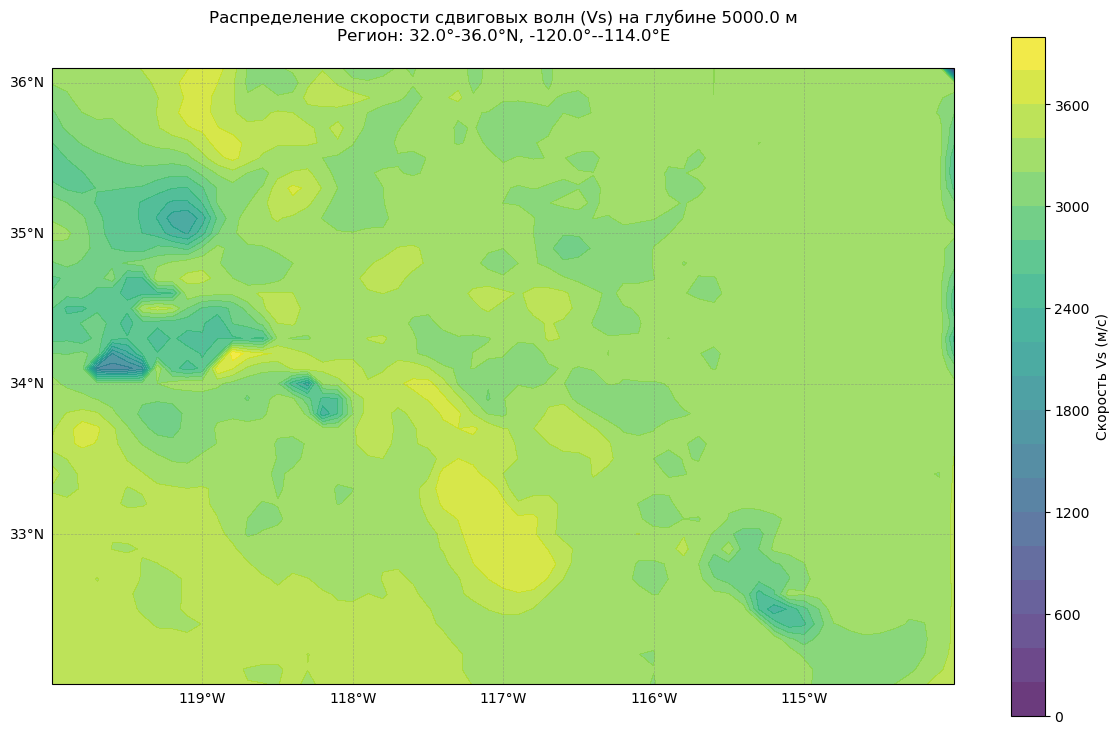

In [ ]:
import numpy as np
import subprocess
import tempfile
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# # Установка путей к библиотекам
# os.environ["LD_LIBRARY_PATH"] = ":".join([
#     "/mnt/disk01/egor/ucvm_final/lib",
#     "/mnt/disk01/egor/ucvm_final/lib/proj/lib",
#     os.environ.get("LD_LIBRARY_PATH", "")
# ])

def query_vs_grid(lons, lats, depth):
    vs_values = np.zeros_like(lons)
    
    with tempfile.NamedTemporaryFile(mode='w+') as f:
        # Записываем все точки во временный файл
        for lon, lat in zip(lons.ravel(), lats.ravel()):
            f.write(f"{lon} {lat} {depth}\n")
        f.flush()
        
        # Запускаем ucvm_query для всех точек сразу
        cmd = [
            "/mnt/disk01/egor/ucvm_final/bin/ucvm_query",
            "-f", "/mnt/disk01/egor/ucvm_final/conf/ucvm.conf",
            "-m", "cvmh",
            "<", f.name
        ]
        
        result = subprocess.run(
            ' '.join(cmd),
            shell=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        
        # Разбираем результаты
        for i, line in enumerate(result.stdout.splitlines()):
            if i == 0 or not line.strip():
                continue
            parts = line.split()
            vs_values.flat[i-1] = float(parts[7])  # Vs находится в 7-м столбце
            
    return vs_values.reshape(lons.shape)

# Параметры области
lat_min, lat_max = 32.0, 36.0
lon_min, lon_max = -120.0, -114.0
depth = 5000.0  # Глубина в метрах
step = 0.1  # Шаг сетки (~1.1 км)

# Создаем сетку
lons = np.arange(lon_min, lon_max + step, step)
lats = np.arange(lat_min, lat_max + step, step)
grid = np.meshgrid(lons, lats)

# Получаем данные
vs_data = query_vs_grid(*grid, depth)
print(vs_data)

# Визуализация
# ... (предыдущие импорты и функция query_vs_grid остаются без изменений)

# Визуализация с улучшенной картой
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# Рисуем данные с улучшенной цветовой шкалой
contour = ax.contourf(grid[0], grid[1], vs_data, 
                     levels=20, cmap='viridis', alpha=0.8)
cbar = plt.colorbar(contour, shrink=0.7, label='Скорость Vs (м/с)')
cbar.ax.tick_params(labelsize=10)

# Настройка осей и сетки
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}



# Заголовок и сохранение
ax.set_title(f'Распределение скорости сдвиговых волн (Vs) на глубине {depth} м\n'
            f'Регион: {lat_min}°-{lat_max}°N, {lon_min}°-{lon_max}°E',
            fontsize=12, pad=20)

plt.tight_layout()
plt.savefig('vs_distribution_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
import numpy as np
import pandas as pd
import psycopg2
from scipy.sparse import coo_matrix, linalg
from scipy.interpolate import RegularGridInterpolator
from pyproj import Transformer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

class ACHTomography:
    def __init__(self, db_params):
        self.db_params = db_params
        self.transformer = Transformer.from_crs(4326, 32611, always_xy=True)  # UTM zone 11N
        
    def fetch_data(self):
        """Загрузка данных из PostgreSQL"""
        conn = psycopg2.connect(**self.db_params)
        
        # Запрос для получения событий и станций
        query = """
        WITH station_locs AS (
            SELECT 
                s.station_nm, 
                s.network_nm,
                ST_X(s.loc) as lon,
                ST_Y(s.loc) as lat
            FROM stations s
            WHERE s.loc IS NOT NULL
        )
        SELECT 
            e.event_id,
            ST_X(e.loc) as event_lon,
            ST_Y(e.loc) as event_lat,
            e.depth as event_depth,
            a.station_nm,
            a.network_nm,
            a.arrival_dttm,
            e.event_dttm,
            sl.lon as station_lon,
            sl.lat as station_lat
        FROM events e
        JOIN arrivals a ON e.event_id = a.event_id
        JOIN station_locs sl ON a.station_nm = sl.station_nm AND a.network_nm = sl.network_nm
        WHERE e.loc IS NOT NULL AND a.arrival_dttm IS NOT NULL AND e.event_dttm::date >= '2018-01-01' AND e.event_dttm::date <= '2018-01-03'
        """
        
        self.df = pd.read_sql(query, conn)
        self.df['travel_time'] = (self.df['arrival_dttm'] - self.df['event_dttm']).dt.total_seconds()
        conn.close()
        
    def setup_grid(self, lons, lats, depths):
        """Инициализация 3D сетки"""
        self.lons = np.array(lons)
        self.lats = np.array(lats)
        self.depths = np.array(depths)
        self.nx, self.ny, self.nz = len(lons), len(lats), len(depths)
        
        # Создаем 3D сетку для модели
        self.grid_lons, self.grid_lats, self.grid_depths = np.meshgrid(
            lons, lats, depths, indexing='ij')
        
    def initialize_model(self, initial_vs):
        """Инициализация начальной модели"""
        self.initial_vs = initial_vs
        self.current_vs = initial_vs.copy()
        
        # Интерполятор для модели
        self.vs_interp = RegularGridInterpolator(
            (self.lons, self.lats, self.depths),
            initial_vs,
            bounds_error=False,
            fill_value=None
        )
        
    def calculate_rays(self):
        """Расчет лучей и матрицы чувствительности"""
        # Преобразование координат в UTM
        utm_coords = self.transformer.transform(
            np.concatenate([self.df['event_lon'], self.df['station_lon']]),
            np.concatenate([self.df['event_lat'], self.df['station_lat']])
        )
        
        event_utm = np.column_stack(utm_coords[:len(self.df)])
        station_utm = np.column_stack(utm_coords[len(self.df):])
        
        # Параметры для разреженной матрицы
        row_ind = []
        col_ind = []
        data = []
        delta_t = []
        
        for i, (_, row) in enumerate(self.df.iterrows()):
            # Упрощенная трассировка лучей - линейный путь
            path_length = np.linalg.norm(station_utm[i] - event_utm[i])
            path_depth = row['event_depth']
            
            # Параметризация луча
            t = np.linspace(0, 1, 100)
            x = event_utm[i,0] + t*(station_utm[i,0] - event_utm[i,0])
            y = event_utm[i,1] + t*(station_utm[i,1] - event_utm[i,1])
            z = t * path_depth
            
            # Обратное преобразование в географические координаты
            lon, lat = self.transformer.transform(x, y, direction='INVERSE')
            
            # Интерполяция вдоль луча
            vs_values = self.vs_interp(np.column_stack([lon, lat, z]))
            
            # Расчет интеграла (суммы) вдоль луча
            ds = path_length / len(t)
            integral = np.sum(ds / vs_values)
            
            # Разница между наблюдаемым и расчетным временем
            delta_t.append(row['travel_time'] - integral)
            
            # Построение матрицы чувствительности
            for j, (ln, lt, dp) in enumerate(zip(lon, lat, z)):
                # Находим ближайший узел сетки
                lon_idx = np.argmin(np.abs(self.lons - ln))
                lat_idx = np.argmin(np.abs(self.lats - lt))
                depth_idx = np.argmin(np.abs(self.depths - dp))
                
                # Добавляем в матрицу
                row_ind.append(i)
                col_ind.append(lon_idx * self.ny * self.nz + 
                              lat_idx * self.nz + 
                              depth_idx)
                data.append(-ds / (vs_values[j]**2))
        
        # Создаем разреженную матрицу
        self.G = coo_matrix((data, (row_ind, col_ind)), 
                            shape=(len(self.df), self.nx*self.ny*self.nz))
        self.delta_t = np.array(delta_t)
        
    def solve_inverse_problem(self, damping=0.1):
        """Решение обратной задачи"""
        # Преобразуем матрицу в CSR формат для эффективности
        G_csr = self.G.tocsr()
        
        # Регуляризация (damped least squares)
        GTG = G_csr.T.dot(G_csr)
        GTG_reg = GTG + damping * np.eye(GTG.shape[0])
        
        # Решение системы
        delta_m = linalg.spsolve(
            GTG_reg,
            G_csr.T.dot(self.delta_t),
            use_umfpack=True
        )
        
        # Обновление модели
        delta_m_3d = delta_m.reshape((self.nx, self.ny, self.nz))
        self.current_vs += delta_m_3d
        
        # Обновление интерполятора
        self.vs_interp = RegularGridInterpolator(
            (self.lons, self.lats, self.depths),
            self.current_vs,
            bounds_error=False,
            fill_value=None
        )
        
    def run_iterations(self, n_iter=3):
        """Итерационный процесс томографии"""
        for i in range(n_iter):
            self.calculate_rays()
            self.solve_inverse_problem(damping=0.1*(i+1))
            print(f"Iteration {i+1}, RMS: {np.sqrt(np.mean(self.delta_t**2)):.3f} s")
            
    def plot_results(self, depth_idx):
        """Визуализация результатов"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8),
                                      subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Начальная модель
        im1 = ax1.contourf(self.lons, self.lats, 
                          self.initial_vs[:, :, depth_idx].T,
                          levels=20, cmap='viridis', alpha=0.8)
        ax1.set_title(f'Initial CVM-H Model at {self.depths[depth_idx]/1000:.1f} km')
        plt.colorbar(im1, ax=ax1, label='Vs (m/s)')
        
        # Уточненная модель
        im2 = ax2.contourf(self.lons, self.lats, 
                          self.current_vs[:, :, depth_idx].T,
                          levels=20, cmap='viridis', alpha=0.8)
        ax2.set_title(f'Refined ACH Model at {self.depths[depth_idx]/1000:.1f} km')
        plt.colorbar(im2, ax=ax2, label='Vs (m/s)')
        
        # Общие настройки
        for ax in (ax1, ax2):
            ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
            ax.add_feature(cfeature.STATES.with_scale('10m'))
            ax.gridlines(draw_labels=True)
            
            # Добавляем станции
            stations = self.df[['station_lon', 'station_lat']].drop_duplicates()
            ax.scatter(stations['station_lon'], stations['station_lat'],
                      c='red', s=20, transform=ccrs.PlateCarree(), 
                      label='Stations')
            ax.legend()
        
        plt.tight_layout()
        plt.savefig(f'vs_tomography_result_{self.depths[depth_idx]}m.png', dpi=300)
        plt.show()

# Пример использования
if __name__ == "__main__":
    # Параметры подключения к БД
    db_params = {
        'dbname': 'gis',
        'user': 'gis',
        'password': '123456',
        'host': '10.0.62.59',
        'port': '55432' 
    }
    
    # Инициализация томографии
    tomography = ACHTomography(db_params)
    tomography.fetch_data()
    
    # Настройка сетки (примерные параметры)
    lons = np.arange(-120, -114 + 0.2, 0.2)
    lats = np.arange(32, 36 + 0.2, 0.2)
    depths = np.array([0, 5000, 10000, 20000])  # В метрах
    
    tomography.setup_grid(lons, lats, depths)
    
    # Получение начальной модели (замените на ваш вызов CVM-H)
    initial_vs = np.random.uniform(3000, 4000, size=(len(lons), len(lats), len(depths)))
    tomography.initialize_model(initial_vs)
    
    # Запуск томографии
    tomography.run_iterations(n_iter=3)
    
    # Визуализация результатов
    for i in range(len(depths)):
        tomography.plot_results(i)

/tmp/ipykernel_1555975/1536123952.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  self.df = pd.read_sql(query, conn)


ValueError: need at least one array to concatenate